
SumSquares: 2D


In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=a11f97749f4c7f0193ba46d84d68713ab0845c220378c5db3deb691665185313
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'SumSquares'
Beta_CBM = 1.5 # Default UCB Acquisition function parameter in pyGPGO https://github.com/josejimenezluna/pyGPGO/blob/master/pyGPGO/acquisition.py#L83
n_test = 500
eps = 1e-08

util_grad_exact = 'dCBM_GP'
util_grad_approx = 'CBM'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - Sum Squares(x) 2-D:

def objfunc(x1_training, x2_training):
            return  operator * (  1 * x1_training ** 2
                            + 2 * x2_training ** 2
                            )
        
# Constraints:
lb = -10
ub = +10
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
                 'x2_training': ('cont', [lb, ub])
                 }
    
# True y bounds:
y_lb = 0
operator = -1 # targets global minimum 
y_global_orig = y_lb * operator # targets global minimum
    
# Test data:
x1_test = np.linspace(lb, ub, n_test)
x2_test = np.linspace(lb, ub, n_test)
x_test = np.column_stack((x1_test, x2_test))


In [5]:
n_start_AcqFunc = iters #multi-start iterations to avoid local optima in AcqFunc optimization


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM,
            'dCBM_GP': self.dCBM_GP
        }

        self.f = mode_dict[mode]

    def CBM(self, tau, mean, std):
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (z + np.sqrt(Beta_CBM))

    def dCBM_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: 

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max AcqFunc.'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        
        self.history.append(self.f_best_min)
          
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], self.GP.y[init_eval], self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(self.GP.y[-1])
        curr_best = str(self.tau)
        max_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + str(self.f_best_min) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         Max AcqFunc.'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], self.GP.y[init_eval], self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(self.GP.y[-1])
        curr_best = str(self.tau)
        max_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            max_acqfunc = BOLD + OKGREEN + str(self.f_best_min) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, max_acqfunc))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1651589596.2620177

In [13]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_new(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.65955991  4.40648987]	 -41.5884450098667	 -5.468172821636052	    
init	 [-9.9977125  -3.95334855]	 -131.21218477957908	 -5.468172821636052	    
init	 [-7.06488218 -8.1532281 ]	 -182.86281732102734	 -5.468172821636052	    
init	 [-6.27479577 -3.08878546]	 -58.4542532110911	 -5.468172821636052	    
init	 [-2.06465052  0.77633468]	 -5.468172821636052	 -5.468172821636052	    
1  	 [ 7.89213327 -8.29911577]	 -200.03641276683908	 -5.468172821636052	 -2.4494900512168254
2  	 [7.66612182 2.47344414]	 -71.00527566059496	 -5.468172821636052	 -2.4494900512168254
3  	 [1.62717855 9.40039978]	 -179.3827421328839	 -5.468172821636052	 -2.4494900512168254
4  	 [-9.56950389  8.95940422]	 -252.11725289788865	 -5.468172821636052	 -2.4494900512168254
5  	 [10. 10.]	 -300.0	 -5.468172821636052	 -2.4494900512156157
6  	 [ 1.85023738 -3.75460325]	 -31.61746941418768	 -5.468172821636052	 -2.4494900066391505
7  	 [  2.0

In [14]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_new(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.28010196 -9.48147536]	 -181.43541115584648	 -4.333099000920773	    
init	 [ 0.99324956 -1.29355215]	 -4.333099000920773	 -4.333099000920773	    
init	 [-1.59264396 -3.39330358]	 -25.565533148780872	 -4.333099000920773	    
init	 [-5.90702732  2.38541933]	 -46.27342248166184	 -4.333099000920773	    
init	 [-4.00690653 -4.6634545 ]	 -59.55091562094812	 -4.333099000920773	    
1  	 [4.01504693 9.2910216 ]	 -188.7667666769868	 -4.333099000920773	 -2.4494900512168254
2  	 [ 9.4582138 -7.7444757]	 -209.411615827435	 -4.333099000920773	 -2.4494900512168254
3  	 [ 9.07319925 -1.03970567]	 -84.48492034594878	 -4.333099000920773	 -2.4494900343839707
4  	 [-10. -10.]	 -300.0	 -4.333099000920773	 -2.449490051216515
5  	 [-10.  10.]	 -300.0	 -4.333099000920773	 -2.449490051216824
6  	 [-3.25263411  9.0402141 ]	 -174.03057068772284	 -4.333099000920773	 -2.4494900384386322
7  	 [-9.45655361 -2.32375462]	 -100.

In [15]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_new(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.01595805 4.16295645]	 -35.692583610916834	 -17.582120911078754	    
init	 [-4.18190522  0.2165521 ]	 -17.582120911078754	 -17.582120911078754	    
init	 [7.85893909 7.92586178]	 -187.4014934415638	 -17.582120911078754	    
init	 [-7.48829379 -5.85514244]	 -124.63992981683481	 -17.582120911078754	    
init	 [-8.97065593 -1.18380313]	 -83.2754475728413	 -17.582120911078754	    
1  	 [ 5.60629529 -3.87272935]	 -61.42661215628989	 -17.582120911078754	 -2.4494900512168254
2  	 [-6.2437035   9.04202486]	 -202.50026057521436	 -17.582120911078754	 -2.449490051216825
3  	 [ 0.21747715 10.        ]	 -200.04729631129734	 -17.582120911078754	 -2.4494894777515115
4  	 [-0.42169096 -8.75441039]	 -153.45722588114134	 -17.582120911078754	 -2.4494900512168254
5  	 [ 6.49032284 -9.62339388]	 -227.34370997575598	 -17.582120911078754	 -2.449488679581663
6  	 [-9.21277105  4.93342182]	 -133.55245206852663	 -17.582120

In [16]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition_new(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [9.34059678 0.94464498]	 -89.0314565014143	 -27.80880071439404	    
init	 [9.4536872  4.29631987]	 -126.28893057280868	 -27.80880071439404	    
init	 [ 3.95457649 -5.67821009]	 -80.12281484649141	 -27.80880071439404	    
init	 [ 9.5254891 -9.8753949]	 -285.78179120922215	 -27.80880071439404	    
init	 [-4.94035275 -1.30416935]	 -27.80880071439404	 -27.80880071439404	    
1  	 [-10. -10.]	 -300.0	 -27.80880071439404	 -2.4494900512168254
2  	 [-0.87952816 10.        ]	 -200.77356978665082	 -27.80880071439404	 -2.4494900512168254
3  	 [-10.           9.26180986]	 -271.5622437964045	 -27.80880071439404	 -2.4494900512168254
4	 [0.97610237 1.99594982]	 -8.92040722633793	 -8.92040722633793	 -2.4494900497129177
5  	 [-9.2450964   2.86617043]	 -101.9016732569988	 -8.92040722633793	 -2.44948969716842
6  	 [-3.5249608  -7.68742692]	 -130.61841401245684	 -8.92040722633793	 -2.449490035824002
7  	 [5.24997409 9.

In [17]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_new(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-5.56013658  7.41464612]	 -140.86907304317228	 -10.04307293518387	    
init	 [-5.86561689  8.37221816]	 -174.59353533361667	 -10.04307293518387	    
init	 [-0.23177622  2.23487726]	 -10.04307293518387	 -10.04307293518387	    
init	 [5.31815713 0.36835976]	 -28.554173077012745	 -10.04307293518387	    
init	 [-4.06398997 -6.24557543]	 -94.53043928694063	 -10.04307293518387	    
1  	 [9.27861058 9.20453431]	 -255.5395178906315	 -10.04307293518387	 -2.4494900512168254
2  	 [ 8.87080164 -7.76615146]	 -199.31733862713008	 -10.04307293518387	 -2.4494900512168254
3  	 [-10. -10.]	 -300.0	 -10.04307293518387	 -2.4494900503000734
4  	 [2.82929545 9.76335526]	 -198.65112458457682	 -10.04307293518387	 -2.449489949669726
5  	 [-10.         -2.9247614]	 -117.1084584489048	 -10.04307293518387	 -2.4494900449437194
6  	 [ 0.88609862 -9.60960082]	 -185.4740267387391	 -10.04307293518387	 -2.449489263594313
7  	 [-5.5

In [18]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_new(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 7.85720303 -3.36040389]	 -84.32026809583151	 -5.629416961321397	    
init	 [ 6.42458246 -9.16606749]	 -209.30884609749882	 -5.629416961321397	    
init	 [-7.8468664   1.90104128]	 -68.80122824744078	 -5.629416961321397	    
init	 [ 0.59634724 -1.62385143]	 -5.629416961321397	 -5.629416961321397	    
init	 [-3.29184301  2.45038864]	 -22.84503944485431	 -5.629416961321397	    
1  	 [10.          7.48434045]	 -212.03070393575945	 -5.629416961321397	 -2.4494900512168254
2  	 [-4.96771714 -9.17248997]	 -192.94735819477367	 -5.629416961321397	 -2.4494900512168254
3  	 [2.46299902 9.4614501 ]	 -185.1044400841216	 -5.629416961321397	 -2.4494900512168254
4  	 [-5.6935267   8.60486508]	 -180.50365249520243	 -5.629416961321397	 -2.44949004682293
5  	 [-10.          -5.39645958]	 -158.24355205364782	 -5.629416961321397	 -2.449489806173355
6  	 [5.27911136 2.46180165]	 -39.989951438565576	 -5.629416961321397	 

In [19]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_new(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-8.47383421  5.59837584]	 -134.48949046062052	 -21.448213419349443	    
init	 [-1.23181537  4.46930356]	 -41.46671767109191	 -21.448213419349443	    
init	 [9.55979024 0.76991741]	 -92.57513506242564	 -21.448213419349443	    
init	 [ 0.02240927 -8.55897733]	 -146.51268814245697	 -21.448213419349443	    
init	 [-4.63122040e+00 -2.34998349e-03]	 -21.448213419349443	 -21.448213419349443	    
1  	 [ 8.12846538 -6.39096762]	 -147.76088362344177	 -21.448213419349443	 -2.4494900512168254
2  	 [ 4.12049415 10.        ]	 -216.97847206013458	 -21.448213419349443	 -2.4494900512168254
3  	 [-9.10467478 -9.8356699 ]	 -276.3759076385656	 -21.448213419349443	 -2.4494900512168254
4  	 [-7.86246511 -2.61028169]	 -75.44549865130998	 -21.448213419349443	 -2.4494900512168254
5	 [3.6305103  0.86654451]	 -14.682403790566307	 -14.682403790566307	 -2.449488749990465
6  	 [-3.1694793   9.87485107]	 -205.07096647226032	 -14

In [20]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_new(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [7.46858806 9.37081326]	 -231.40408972112363	 -0.5791878792948744	    
init	 [7.3838908  0.61711383]	 -55.28350237060649	 -0.5791878792948744	    
init	 [-5.34543344 -9.77202391]	 -219.5585614355461	 -0.5791878792948744	    
init	 [-1.39062363 -1.9529728 ]	 -9.562039601098967	 -0.5791878792948744	    
init	 [ 0.45349343 -0.43216408]	 -0.5791878792948744	 -0.5791878792948744	    
1  	 [ 9.69498875 -9.42535902]	 -271.6675921188219	 -0.5791878792948744	 -2.4494900512168254
2  	 [-9.83383251  5.77166529]	 -163.3285022998636	 -0.5791878792948744	 -2.4494900512168254
3  	 [-1.86374832  6.75869309]	 -94.83342240463715	 -0.5791878792948744	 -2.4494900512159568
4  	 [-9.65586204 -5.07440767]	 -144.73489822426617	 -0.5791878792948744	 -2.4494898875159086
5  	 [ 4.95960714 -5.5151507 ]	 -85.43147739534227	 -0.5791878792948744	 -2.449489162961908
6  	 [  0.80191989 -10.        ]	 -200.64307551603477	 -0.5791878

In [21]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_new(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-9.79251692  0.03749184]	 -95.896198949837	 -53.418783741178075	    
init	 [-0.08453414 -7.32340942]	 -107.27179711012016	 -53.418783741178075	    
init	 [-7.15777829 -5.62882649]	 -114.6011653140891	 -53.418783741178075	    
init	 [-1.62983639 -5.03797663]	 -53.418783741178075	 -53.418783741178075	    
init	 [-8.31880698 -3.0900272 ]	 -88.29908569649677	 -53.418783741178075	    
1  	 [6.0747954  9.66718496]	 -223.8120694300478	 -53.418783741178075	 -2.4494900512168254
2  	 [-3.94738717  9.4159639 ]	 -192.90261763630335	 -53.418783741178075	 -2.4494900512168254
3  	 [ 10. -10.]	 -300.0	 -53.418783741178075	 -2.4494900512168254
4	 [6.86960633 0.80631353]	 -48.49177417615124	 -48.49177417615124	 -2.4494900512168245
5	 [-3.38985889  2.55712881]	 -24.56895874514872	 -24.56895874514872	 -2.4494900436478426
6  	 [-9.43535893  5.95042309]	 -159.84106794164182	 -24.56895874514872	 -2.4494888326693416
7  	 

In [22]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_new(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 5.42641287 -9.58496101]	 -213.18891181932327	 -56.66743785259343	    
init	 [2.6729647  4.97607765]	 -56.66743785259343	 -56.66743785259343	    
init	 [-0.02985975 -5.50406709]	 -60.59040065376497	 -56.66743785259343	    
init	 [-6.0387427   5.21061424]	 -90.76741505398337	 -56.66743785259343	    
init	 [-6.61778327 -8.23320372]	 -179.36634226756874	 -56.66743785259343	    
1  	 [10. 10.]	 -300.0	 -56.66743785259343	 -2.4494900512168254
2	 [2.11155129 0.26933255]	 -4.603728884330075	 -4.603728884330075	 -2.4494900512168254
3  	 [8.50713746 1.33499849]	 -75.93582966295617	 -4.603728884330075	 -2.4494900512168254
4  	 [ 7.31105236 -3.79432586]	 -82.24530415903486	 -4.603728884330075	 -2.449489879784585
5  	 [-7.55328158 -0.82551542]	 -58.415013996797406	 -4.603728884330075	 -2.4494898745134797
6  	 [-10.           9.95089491]	 -298.0406188589491	 -4.603728884330075	 -2.4494900503163186
7  	 [-2.6448

In [23]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_new(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-6.39460622 -9.61049517]	 -225.61422357508457	 -2.716881462565864	    
init	 [-0.73562947  4.49867858]	 -41.01736871863572	 -2.716881462565864	    
init	 [-1.59592791 -0.29145804]	 -2.716881462565864	 -2.716881462565864	    
init	 [-9.74438371 -0.25256785]	 -95.08059489374317	 -2.716881462565864	    
init	 [8.83613305 7.01590179]	 -176.5230030066306	 -2.716881462565864	    
1  	 [ 1.99086793 -8.88652641]	 -161.90425830617428	 -2.716881462565864	 -2.4494900512168254
2  	 [ 6.89877062 -3.95670624]	 -78.9040846386408	 -2.716881462565864	 -2.4494900512168254
3  	 [ 10. -10.]	 -300.0	 -2.716881462565864	 -2.449490047439652
4  	 [-9.61343956  9.53289229]	 -274.1702911788162	 -2.716881462565864	 -2.4494900512168254
5  	 [ 4.38485979 10.        ]	 -219.22699538443737	 -2.716881462565864	 -2.449489164443342
6  	 [5.24860912 2.85966119]	 -43.90322199383101	 -2.716881462565864	 -2.4494900512165607
7  	 [-3.13

In [24]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_new(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-6.91674315  4.80099393]	 -93.94042127407329	 -23.318590147261595	    
init	 [-4.7336997   0.67478787]	 -23.318590147261595	 -23.318590147261595	    
init	 [-9.70850075  8.37494016]	 -234.53423225249676	 -23.318590147261595	    
init	 [ 8.01429708 -9.33157145]	 -238.38540908259807	 -23.318590147261595	    
init	 [ 9.13898673 -7.25581357]	 -188.8147395776428	 -23.318590147261595	    
1  	 [4.66251955 4.05244711]	 -54.583743654491954	 -23.318590147261595	 -2.4494900512168254
2  	 [-3.75432006 -8.6025265 ]	 -162.1018436659056	 -23.318590147261595	 -2.4494900512168254
3  	 [ 1.15529981 -4.1835841 ]	 -36.3394694490003	 -23.318590147261595	 -2.449490024030086
4  	 [10. 10.]	 -300.0	 -23.318590147261595	 -2.449490051216455
5  	 [-10.          -5.06744508]	 -151.35799937625652	 -23.318590147261595	 -2.449490050685761
6  	 [ 7.60598726 -1.00341282]	 -59.86471683488458	 -23.318590147261595	 -2.44948895082865

In [25]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_new(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 5.55404821 -5.2491756 ]	 -85.95514048001408	 -47.45541115581226	    
init	 [6.48557065 9.31498396]	 -215.600479080162	 -47.45541115581226	    
init	 [ 9.45202228 -0.93101505]	 -91.0743031984701	 -47.45541115581226	    
init	 [2.18084926 5.51053029]	 -65.48799167425372	 -47.45541115581226	    
init	 [2.8322669  4.44036459]	 -47.45541115581226	 -47.45541115581226	    
1  	 [-8.69830926  2.59657998]	 -89.14503917528086	 -47.45541115581226	 -2.4494900512168254
2  	 [-5.9673185  -6.48540274]	 -119.72978734259729	 -47.45541115581226	 -2.4494900512168254
3  	 [ -0.09997355 -10.        ]	 -200.0099947104059	 -47.45541115581226	 -2.4494900469918806
4  	 [-10.  10.]	 -300.0	 -47.45541115581226	 -2.4494900511928837
5	 [ 0.01886313 -1.74696988]	 -6.1041633558475406	 -6.1041633558475406	 -2.4494900288590276
6  	 [ 10. -10.]	 -300.0	 -6.1041633558475406	 -2.4494900236797226
7  	 [-2.56400012 10.        ]	 -206.

In [26]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_new(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.27886688 5.46330104]	 -59.77308327621332	 -26.48525945153859	    
init	 [ 7.40855371 -9.83906103]	 -248.5009120212351	 -26.48525945153859	    
init	 [-3.80528149  9.15207479]	 -182.0011130426615	 -26.48525945153859	    
init	 [ 0.26233425 -3.6343115 ]	 -26.48525945153859	 -26.48525945153859	    
init	 [ 0.78399875 -5.57490115]	 -62.773699734431055	 -26.48525945153859	    
1  	 [ 9.82765998 -0.95725402]	 -98.41557117870066	 -26.48525945153859	 -2.4494900512168254
2  	 [-8.1477833   0.47898709]	 -66.84523003287876	 -26.48525945153859	 -2.4494900512168254
3  	 [ -7.20695019 -10.        ]	 -251.94013110331883	 -26.48525945153859	 -2.4494900512168254
4  	 [10.          9.26137472]	 -271.5461234709518	 -26.48525945153859	 -2.4494900512168254
5  	 [-10.  10.]	 -300.0	 -26.48525945153859	 -2.4494897560991653
6	 [3.92353293 0.90665186]	 -17.038145794849914	 -17.038145794849914	 -2.4494881505458306
7  	 [ 

In [27]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_new(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 6.97635395 -6.4220815 ]	 -131.15577599697437	 -20.897907943365695	    
init	 [-8.91273571 -2.76923108]	 -94.77413943464936	 -20.897907943365695	    
init	 [-4.49198143  0.6000045 ]	 -20.897907943365695	 -20.897907943365695	    
init	 [-3.88162169 -3.91051282]	 -45.651207890195394	 -20.897907943365695	    
init	 [-7.76517448 -5.00201972]	 -110.33833725681367	 -20.897907943365695	    
1  	 [-1.08003705  9.49213271]	 -181.3676469637466	 -20.897907943365695	 -2.4494900512168254
2  	 [10. 10.]	 -300.0	 -20.897907943365695	 -2.4494900512168254
3  	 [3.69182439 3.52226735]	 -38.44230185968878	 -20.897907943365695	 -2.449490051198033
4  	 [-9.85336983  7.92181089]	 -222.59907269893387	 -20.897907943365695	 -2.449490051216825
5  	 [ -2.24037026 -10.        ]	 -205.01925888356232	 -20.897907943365695	 -2.449489998553225
6  	 [10.          2.38189307]	 -111.34682918560738	 -20.897907943365695	 -2.44949002824

In [28]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_new(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-5.53417842  0.46326683]	 -31.056363058280656	 -31.056363058280656	    
init	 [ 1.01402913 -9.087961  ]	 -166.21032525826828	 -31.056363058280656	    
init	 [-2.78542329 -5.53838117]	 -69.10591480510183	 -31.056363058280656	    
init	 [ 3.77452324 -6.7253715 ]	 -104.70826928786903	 -31.056363058280656	    
init	 [-8.59350266  8.8202172 ]	 -229.44075111810224	 -31.056363058280656	    
1  	 [3.97836507 9.61245232]	 -200.62586785623955	 -31.056363058280656	 -2.4494900512168254
2  	 [-10. -10.]	 -300.0	 -31.056363058280656	 -2.449490051216817
3  	 [ 10. -10.]	 -300.0	 -31.056363058280656	 -2.4494900502747385
4  	 [ 8.8300141  -0.10570929]	 -77.99149800000582	 -31.056363058280656	 -2.44949005121678
5  	 [-2.22531694  5.42968011]	 -63.91488757640133	 -31.056363058280656	 -2.4494900512168254
6  	 [-10.          -3.86254076]	 -129.83844217437115	 -31.056363058280656	 -2.4494889965322812
7  	 [9.3858397  6.

In [29]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_new(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.10669995  0.61173511]	 -17.613424143360255	 -12.137436774523842	    
init	 [-6.16958426 -8.64199284]	 -187.43185031516856	 -12.137436774523842	    
init	 [5.7397092  3.12667044]	 -52.49639772521824	 -12.137436774523842	    
init	 [2.75041792 1.51205788]	 -12.137436774523842	 -12.137436774523842	    
init	 [-9.21874168 -2.84372791]	 -101.1587749488933	 -12.137436774523842	    
1  	 [-10.  10.]	 -300.0	 -12.137436774523842	 -2.4494900512168254
2  	 [ 4.54825031 -8.71744454]	 -172.6742595800706	 -12.137436774523842	 -2.4494900512168254
3  	 [9.12376544 9.73620918]	 -272.83063435528607	 -12.137436774523842	 -2.4494900511889055
4  	 [-0.05385845  7.96254756]	 -126.80722802594437	 -12.137436774523842	 -2.4494900510965807
5  	 [ 9.06636127 -2.74323799]	 -97.24961590065784	 -12.137436774523842	 -2.4494900477398445
6  	 [ 0.70729256 -3.78878158]	 -29.209994554081746	 -12.137436774523842	 -2.4494891674858

In [30]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_new(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [3.00748483 0.10906747]	 -9.068756459576363	 -9.068756459576363	    
init	 [ 7.57202942 -6.36319549]	 -138.3161432668939	 -9.068756459576363	    
init	 [7.04466137 5.00272572]	 -99.6817831686958	 -9.068756459576363	    
init	 [3.32203335 9.75790897]	 -201.4694803352836	 -9.068756459576363	    
init	 [-4.86063155 -9.43388149]	 -201.6219791510955	 -9.068756459576363	    
1  	 [-6.1664519   4.28513481]	 -74.74988979878172	 -9.068756459576363	 -2.4494900512168254
2  	 [-10.          -2.02144221]	 -108.17245724964353	 -9.068756459576363	 -2.4494900512148043
3  	 [-10.  10.]	 -300.0	 -9.068756459576363	 -2.4494900512168254
4  	 [-3.21759186  9.95405735]	 -208.5194127196915	 -9.068756459576363	 -2.449490051076426
5  	 [ 4.59940623 -9.59713586]	 -205.36457092968183	 -9.068756459576363	 -2.4494900512168254
6  	 [-0.88289138 -3.88087663]	 -30.901904052010547	 -9.068756459576363	 -2.4494892251561406
7  	 [10. 

In [31]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_new(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-8.04932797  5.22499433]	 -119.39281225846176	 -87.03025225125222	    
init	 [-5.06124054 -7.23736625]	 -130.3750962570555	 -87.03025225125222	    
init	 [-3.37106873 -8.3400087 ]	 -150.4755946408245	 -87.03025225125222	    
init	 [3.43954163 6.13187596]	 -87.03025225125222	 -87.03025225125222	    
init	 [9.65483829 2.7132147 ]	 -107.93897039562282	 -87.03025225125222	    
1  	 [ 10. -10.]	 -300.0	 -87.03025225125222	 -2.4494900512168254
2	 [ 4.81772344 -2.77685984]	 -38.632360201328204	 -38.632360201328204	 -2.449490051089066
3  	 [10. 10.]	 -300.0	 -38.632360201328204	 -2.449490051055675
4  	 [-9.64931371 -1.76781368]	 -99.35958538505903	 -38.632360201328204	 -2.4494900502986052
5  	 [ 2.60148425 -9.15315418]	 -174.32818323665992	 -38.632360201328204	 -2.44948912925115
6	 [-1.7320768   1.94605445]	 -10.574345906063899	 -10.574345906063899	 -2.449490039997568
7  	 [-1.10594833 10.        ]	 -201.2

In [32]:
### ESTIMATED GP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_new(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.76261602 7.95427456]	 -129.64778273349407	 -6.161449614183514	    
init	 [7.83061459 6.31674955]	 -141.12117450686426	 -6.161449614183514	    
init	 [-9.28220829  3.83515164]	 -115.57616682517047	 -6.161449614183514	    
init	 [-2.42638116  0.37021891]	 -6.161449614183514	 -6.161449614183514	    
init	 [ 3.15902931 -6.12299564]	 -84.96161746112533	 -6.161449614183514	    
1  	 [-10. -10.]	 -300.0	 -6.161449614183514	 -2.4494900512168254
2  	 [-4.01456245 -6.6872889 ]	 -105.55637735489252	 -6.161449614183514	 -2.4494900505944934
3  	 [ 10. -10.]	 -300.0	 -6.161449614183514	 -2.449490051215536
4  	 [6.75943299 0.83853385]	 -47.096212361777255	 -6.161449614183514	 -2.4494900512168236
5  	 [-7.43971571 10.        ]	 -255.34936986894027	 -6.161449614183514	 -2.4494899920724613
6  	 [-10.          -3.70511096]	 -127.45569446085743	 -6.161449614183514	 -2.4494899802874506
7  	 [-4.09143665  4.94261142]	

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1651589707.6625547

In [34]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.65955991  4.40648987]	 -41.5884450098667	 -5.468172821636052	    
init	 [-9.9977125  -3.95334855]	 -131.21218477957908	 -5.468172821636052	    
init	 [-7.06488218 -8.1532281 ]	 -182.86281732102734	 -5.468172821636052	    
init	 [-6.27479577 -3.08878546]	 -58.4542532110911	 -5.468172821636052	    
init	 [-2.06465052  0.77633468]	 -5.468172821636052	 -5.468172821636052	    
1  	 [ 7.89213327 -8.29911577]	 -200.03641276683908	 -5.468172821636052	 -2.449489748092488
2  	 [7.66612182 2.47344414]	 -71.00527566059496	 -5.468172821636052	 -2.449489748092488
3  	 [10. 10.]	 -300.0	 -5.468172821636052	 -2.449489748092488
4  	 [-9.56950389  8.95940422]	 -252.11725289788865	 -5.468172821636052	 -2.449489748092488
5  	 [ 2.56152397 -4.28847437]	 -43.34342980630102	 -5.468172821636052	 -2.4494897262062167
6  	 [ 0.66198287 10.        ]	 -200.4382213193613	 -5.468172821636052	 -2.4494895223488755
7  	 [  1.726

In [35]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-1.28010196 -9.48147536]	 -181.43541115584648	 -4.333099000920773	    
init	 [ 0.99324956 -1.29355215]	 -4.333099000920773	 -4.333099000920773	    
init	 [-1.59264396 -3.39330358]	 -25.565533148780872	 -4.333099000920773	    
init	 [-5.90702732  2.38541933]	 -46.27342248166184	 -4.333099000920773	    
init	 [-4.00690653 -4.6634545 ]	 -59.55091562094812	 -4.333099000920773	    
1  	 [5.88961714 8.24884114]	 -170.77435028780866	 -4.333099000920773	 -2.449489748092488
2  	 [ 9.4582138 -7.7444757]	 -209.411615827435	 -4.333099000920773	 -2.449489748092488
3  	 [-10. -10.]	 -300.0	 -4.333099000920773	 -2.449489748092178
4  	 [8.51803193 1.4054842 ]	 -76.50763960826586	 -4.333099000920773	 -2.4494897479097006
5  	 [0.21792083 5.97963749]	 -71.55961854077546	 -4.333099000920773	 -2.449489074825717
6  	 [-8.60678819  8.70307127]	 -225.56370193566426	 -4.333099000920773	 -2.4494897467904004
7  	 [ 5.5221699

In [36]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.01595805 4.16295645]	 -35.692583610916834	 -17.582120911078754	    
init	 [-4.18190522  0.2165521 ]	 -17.582120911078754	 -17.582120911078754	    
init	 [7.85893909 7.92586178]	 -187.4014934415638	 -17.582120911078754	    
init	 [-7.48829379 -5.85514244]	 -124.63992981683481	 -17.582120911078754	    
init	 [-8.97065593 -1.18380313]	 -83.2754475728413	 -17.582120911078754	    
1  	 [ 5.60629529 -3.87272935]	 -61.42661215628989	 -17.582120911078754	 -2.449489748092488
2  	 [-6.2437035   9.04202486]	 -202.50026057521436	 -17.582120911078754	 -2.4494897480924878
3  	 [10.          1.91076445]	 -107.3020415945788	 -17.582120911078754	 -2.449489616274744
4  	 [-0.42169096 -8.75441039]	 -153.45722588114134	 -17.582120911078754	 -2.449489748092488
5  	 [ 6.56856688 -9.15868109]	 -210.908949615437	 -17.582120911078754	 -2.449473193144381
6  	 [-9.21277105  4.93342182]	 -133.55245206852663	 -17.58212091107

In [37]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [9.34059678 0.94464498]	 -89.0314565014143	 -27.80880071439404	    
init	 [9.4536872  4.29631987]	 -126.28893057280868	 -27.80880071439404	    
init	 [ 3.95457649 -5.67821009]	 -80.12281484649141	 -27.80880071439404	    
init	 [ 9.5254891 -9.8753949]	 -285.78179120922215	 -27.80880071439404	    
init	 [-4.94035275 -1.30416935]	 -27.80880071439404	 -27.80880071439404	    
1  	 [-10. -10.]	 -300.0	 -27.80880071439404	 -2.449489748092488
2  	 [-0.24524722  6.20288844]	 -77.01179625821773	 -27.80880071439404	 -2.449489748092488
3  	 [-7.30494786  4.8008946 ]	 -99.45944115815726	 -27.80880071439404	 -2.4494897410279033
4  	 [-4.2513019  -7.81752317]	 -140.30090476847727	 -27.80880071439404	 -2.449488817529922
5  	 [-10.          -3.79206778]	 -128.75955615659214	 -27.80880071439404	 -2.4494873663564554
6  	 [ 4.38381412 10.        ]	 -219.21782623856336	 -27.80880071439404	 -2.4494891147779128
7	 [1.4516

In [38]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-5.56013658  7.41464612]	 -140.86907304317228	 -10.04307293518387	    
init	 [-5.86561689  8.37221816]	 -174.59353533361667	 -10.04307293518387	    
init	 [-0.23177622  2.23487726]	 -10.04307293518387	 -10.04307293518387	    
init	 [5.31815713 0.36835976]	 -28.554173077012745	 -10.04307293518387	    
init	 [-4.06398997 -6.24557543]	 -94.53043928694063	 -10.04307293518387	    
1  	 [9.27861058 9.20453431]	 -255.5395178906315	 -10.04307293518387	 -2.449489748092488
2  	 [ 8.87080164 -7.76615146]	 -199.31733862713008	 -10.04307293518387	 -2.449489748092488
3  	 [-10. -10.]	 -300.0	 -10.04307293518387	 -2.4494897471757366
4  	 [2.82929545 9.76335526]	 -198.65112458457682	 -10.04307293518387	 -2.4494896465453895
5  	 [-7.37525338  1.74211613]	 -60.4642997241582	 -10.04307293518387	 -2.4494887794904097
6  	 [ 2.24805699 -4.75531731]	 -50.279845607581954	 -10.04307293518387	 -2.449489457558506
7  	 [-9.27

In [39]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 7.85720303 -3.36040389]	 -84.32026809583151	 -5.629416961321397	    
init	 [ 6.42458246 -9.16606749]	 -209.30884609749882	 -5.629416961321397	    
init	 [-7.8468664   1.90104128]	 -68.80122824744078	 -5.629416961321397	    
init	 [ 0.59634724 -1.62385143]	 -5.629416961321397	 -5.629416961321397	    
init	 [-3.29184301  2.45038864]	 -22.84503944485431	 -5.629416961321397	    
1  	 [10. 10.]	 -300.0	 -5.629416961321397	 -2.449489748092488
2  	 [-4.96771714 -9.17248997]	 -192.94735819477367	 -5.629416961321397	 -2.449489748092488
3  	 [2.46299902 9.4614501 ]	 -185.1044400841216	 -5.629416961321397	 -2.449489748092488
4  	 [-5.6935267   8.60486508]	 -180.50365249520243	 -5.629416961321397	 -2.449489743698593
5  	 [7.35584953 3.03387552]	 -72.51732359276915	 -5.629416961321397	 -2.4494896987714627
6  	 [-10.         -3.6046608]	 -125.98715897811034	 -5.629416961321397	 -2.449488861815158
7  	 [-10.    

In [40]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-8.47383421  5.59837584]	 -134.48949046062052	 -21.448213419349443	    
init	 [-1.23181537  4.46930356]	 -41.46671767109191	 -21.448213419349443	    
init	 [9.55979024 0.76991741]	 -92.57513506242564	 -21.448213419349443	    
init	 [ 0.02240927 -8.55897733]	 -146.51268814245697	 -21.448213419349443	    
init	 [-4.63122040e+00 -2.34998349e-03]	 -21.448213419349443	 -21.448213419349443	    
1  	 [ 8.12846538 -6.39096762]	 -147.76088362344177	 -21.448213419349443	 -2.449489748092488
2  	 [10. 10.]	 -300.0	 -21.448213419349443	 -2.449489748092488
3  	 [-9.10467478 -9.8356699 ]	 -276.3759076385656	 -21.448213419349443	 -2.449489748092488
4  	 [-7.86246511 -2.61028169]	 -75.44549865130998	 -21.448213419349443	 -2.449489748092488
5  	 [ 0.93762965 10.        ]	 -200.8791493663554	 -21.448213419349443	 -2.449489298895144
6  	 [5.56833589 5.62526631]	 -94.29360679492842	 -21.448213419349443	 -2.449488900626

In [41]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [7.46858806 9.37081326]	 -231.40408972112363	 -0.5791878792948744	    
init	 [7.3838908  0.61711383]	 -55.28350237060649	 -0.5791878792948744	    
init	 [-5.34543344 -9.77202391]	 -219.5585614355461	 -0.5791878792948744	    
init	 [-1.39062363 -1.9529728 ]	 -9.562039601098967	 -0.5791878792948744	    
init	 [ 0.45349343 -0.43216408]	 -0.5791878792948744	 -0.5791878792948744	    
1  	 [ 9.69498875 -9.42535902]	 -271.6675921188219	 -0.5791878792948744	 -2.449489748092488
2  	 [-9.83383251  5.77166529]	 -163.3285022998636	 -0.5791878792948744	 -2.449489748092488
3  	 [-3.97152767  9.51013426]	 -196.65833950916016	 -0.5791878792948744	 -2.449489745495122
4  	 [-9.65586204 -5.07440767]	 -144.73489822426617	 -0.5791878792948744	 -2.4494895843915714
5  	 [1.10947828 5.5318851 ]	 -62.4344475515165	 -0.5791878792948744	 -2.449489656525316
6  	 [ 3.77011518 -4.40569277]	 -53.034026014752534	 -0.57918787929487

In [42]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-9.79251692  0.03749184]	 -95.896198949837	 -53.418783741178075	    
init	 [-0.08453414 -7.32340942]	 -107.27179711012016	 -53.418783741178075	    
init	 [-7.15777829 -5.62882649]	 -114.6011653140891	 -53.418783741178075	    
init	 [-1.62983639 -5.03797663]	 -53.418783741178075	 -53.418783741178075	    
init	 [-8.31880698 -3.0900272 ]	 -88.29908569649677	 -53.418783741178075	    
1  	 [6.0747954  9.66718496]	 -223.8120694300478	 -53.418783741178075	 -2.449489748092488
2  	 [-3.94738717  9.4159639 ]	 -192.90261763630335	 -53.418783741178075	 -2.449489748092488
3	 [4.07561386 0.71776482]	 -17.64100099927903	 -17.64100099927903	 -2.449489748092345
4  	 [ 8.66970884 -6.33785621]	 -155.50069423954056	 -17.64100099927903	 -2.4494897480924838
5  	 [10.          1.04559498]	 -102.18653772050641	 -17.64100099927903	 -2.4494895482227497
6  	 [-9.43535893  5.95042309]	 -159.84106794164182	 -17.64100099927903	

In [43]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 5.42641287 -9.58496101]	 -213.18891181932327	 -56.66743785259343	    
init	 [2.6729647  4.97607765]	 -56.66743785259343	 -56.66743785259343	    
init	 [-0.02985975 -5.50406709]	 -60.59040065376497	 -56.66743785259343	    
init	 [-6.0387427   5.21061424]	 -90.76741505398337	 -56.66743785259343	    
init	 [-6.61778327 -8.23320372]	 -179.36634226756874	 -56.66743785259343	    
1  	 [10. 10.]	 -300.0	 -56.66743785259343	 -2.449489748092488
2	 [2.11155129 0.26933255]	 -4.603728884330075	 -4.603728884330075	 -2.449489748092488
3  	 [8.50713746 1.33499849]	 -75.93582966295617	 -4.603728884330075	 -2.449489748092488
4  	 [-10.          -2.68139879]	 -114.37979888989878	 -4.603728884330075	 -2.4494897480752695
5  	 [-2.22389033  8.98150291]	 -166.28047723102065	 -4.603728884330075	 -2.44948907977756
6  	 [ 6.96012162 -4.09079957]	 -81.91257524640974	 -4.603728884330075	 -2.4494896189167523
7  	 [-4.2407413

In [44]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-6.39460622 -9.61049517]	 -225.61422357508457	 -2.716881462565864	    
init	 [-0.73562947  4.49867858]	 -41.01736871863572	 -2.716881462565864	    
init	 [-1.59592791 -0.29145804]	 -2.716881462565864	 -2.716881462565864	    
init	 [-9.74438371 -0.25256785]	 -95.08059489374317	 -2.716881462565864	    
init	 [8.83613305 7.01590179]	 -176.5230030066306	 -2.716881462565864	    
1  	 [ 1.99086793 -8.88652641]	 -161.90425830617428	 -2.716881462565864	 -2.449489748092488
2  	 [ 4.79903036 -1.6267314 ]	 -28.32320242923278	 -2.716881462565864	 -2.449489748092488
3  	 [10.          0.90638328]	 -101.64306131053262	 -2.716881462565864	 -2.449488630837071
4  	 [-5.39498866 -3.76996454]	 -57.531167855393136	 -2.716881462565864	 -2.449477083647769
5  	 [-7.89611862  5.10567265]	 -114.48447569496835	 -2.716881462565864	 -2.4494896934643373
6  	 [-10.          -6.05434207]	 -173.31011584287148	 -2.716881462565864	

In [45]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-6.91674315  4.80099393]	 -93.94042127407329	 -23.318590147261595	    
init	 [-4.7336997   0.67478787]	 -23.318590147261595	 -23.318590147261595	    
init	 [-9.70850075  8.37494016]	 -234.53423225249676	 -23.318590147261595	    
init	 [ 8.01429708 -9.33157145]	 -238.38540908259807	 -23.318590147261595	    
init	 [ 9.13898673 -7.25581357]	 -188.8147395776428	 -23.318590147261595	    
1  	 [4.66251955 4.05244711]	 -54.583743654491954	 -23.318590147261595	 -2.449489748092488
2  	 [-3.75432006 -8.6025265 ]	 -162.1018436659056	 -23.318590147261595	 -2.449489748092488
3	 [ 0.87886819 -1.89091226]	 -7.923507634979323	 -7.923507634979323	 -2.449489684994526
4  	 [10. 10.]	 -300.0	 -7.923507634979323	 -2.449489748092118
5  	 [-10. -10.]	 -300.0	 -7.923507634979323	 -2.4494896447944448
6  	 [-10.          -1.89916176]	 -107.21363079910743	 -7.923507634979323	 -2.4494893446855506
7  	 [2.84326371 9.57059691]	

In [46]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 5.55404821 -5.2491756 ]	 -85.95514048001408	 -47.45541115581226	    
init	 [6.48557065 9.31498396]	 -215.600479080162	 -47.45541115581226	    
init	 [ 9.45202228 -0.93101505]	 -91.0743031984701	 -47.45541115581226	    
init	 [2.18084926 5.51053029]	 -65.48799167425372	 -47.45541115581226	    
init	 [2.8322669  4.44036459]	 -47.45541115581226	 -47.45541115581226	    
1  	 [-8.69830926  2.59657998]	 -89.14503917528086	 -47.45541115581226	 -2.449489748092488
2  	 [ -3.08551419 -10.        ]	 -209.52039779818688	 -47.45541115581226	 -2.449489748092488
3  	 [-10. -10.]	 -300.0	 -47.45541115581226	 -2.4494897437437633
4  	 [-5.68974606  9.11900061]	 -198.68555458020188	 -47.45541115581226	 -2.4494897478134265
5	 [-4.36156556 -3.65129573]	 -45.68717513432111	 -45.68717513432111	 -2.4494896659945393
6	 [-2.84646599  2.02448875]	 -16.29947808404184	 -16.29947808404184	 -2.4494873211988284
7  	 [-10.       

In [47]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [0.27886688 5.46330104]	 -59.77308327621332	 -26.48525945153859	    
init	 [ 7.40855371 -9.83906103]	 -248.5009120212351	 -26.48525945153859	    
init	 [-3.80528149  9.15207479]	 -182.0011130426615	 -26.48525945153859	    
init	 [ 0.26233425 -3.6343115 ]	 -26.48525945153859	 -26.48525945153859	    
init	 [ 0.78399875 -5.57490115]	 -62.773699734431055	 -26.48525945153859	    
1  	 [-10. -10.]	 -300.0	 -26.48525945153859	 -2.449489748092488
2  	 [10. 10.]	 -300.0	 -26.48525945153859	 -2.449489748092488
3  	 [-8.40655166 -0.09704184]	 -70.68894507141226	 -26.48525945153859	 -2.449489748092488
4  	 [ 7.59696716 -1.03928139]	 -59.874121691821465	 -26.48525945153859	 -2.449489748091595
5  	 [ 3.83886216 10.        ]	 -214.73686267179238	 -26.48525945153859	 -2.4494870949600958
6  	 [-4.96348562 -6.36426737]	 -105.64398773961763	 -26.48525945153859	 -2.44948729734659
7  	 [6.09938165 4.45314171]	 -76.86339

In [48]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 6.97635395 -6.4220815 ]	 -131.15577599697437	 -20.897907943365695	    
init	 [-8.91273571 -2.76923108]	 -94.77413943464936	 -20.897907943365695	    
init	 [-4.49198143  0.6000045 ]	 -20.897907943365695	 -20.897907943365695	    
init	 [-3.88162169 -3.91051282]	 -45.651207890195394	 -20.897907943365695	    
init	 [-7.76517448 -5.00201972]	 -110.33833725681367	 -20.897907943365695	    
1  	 [10. 10.]	 -300.0	 -20.897907943365695	 -2.449489748092488
2  	 [-9.69991687  7.99454818]	 -221.91398842692476	 -20.897907943365695	 -2.449489748092488
3  	 [0.20513286 9.70412013]	 -188.3819746546224	 -20.897907943365695	 -2.449489748092488
4  	 [8.17696818 1.09984692]	 -69.28213505909017	 -20.897907943365695	 -2.4494897480759805
5  	 [1.2981086  3.27985936]	 -23.200040829137844	 -20.897907943365695	 -2.449489676212509
6  	 [-0.62952455 -9.52479128]	 -181.8395990317211	 -20.897907943365695	 -2.4494897316038236
7	

In [49]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-5.53417842  0.46326683]	 -31.056363058280656	 -31.056363058280656	    
init	 [ 1.01402913 -9.087961  ]	 -166.21032525826828	 -31.056363058280656	    
init	 [-2.78542329 -5.53838117]	 -69.10591480510183	 -31.056363058280656	    
init	 [ 3.77452324 -6.7253715 ]	 -104.70826928786903	 -31.056363058280656	    
init	 [-8.59350266  8.8202172 ]	 -229.44075111810224	 -31.056363058280656	    
1  	 [10.          9.77978534]	 -291.28840247255073	 -31.056363058280656	 -2.449489748092488
2  	 [-10. -10.]	 -300.0	 -31.056363058280656	 -2.44948974809248
3  	 [0.85375082 9.40301345]	 -177.56221418768533	 -31.056363058280656	 -2.449489748092488
4  	 [5.7976487  1.62279444]	 -38.87965405424715	 -31.056363058280656	 -2.4494897480924833
5	 [-0.153885    1.10463608]	 -2.4641223318645973	 -2.4641223318645973	 -2.449489748092488
6  	 [-10.        -3.229127]	 -120.8545223413631	 -2.4641223318645973	 -2.4494889373087294
7 

In [50]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-4.10669995  0.61173511]	 -17.613424143360255	 -12.137436774523842	    
init	 [-6.16958426 -8.64199284]	 -187.43185031516856	 -12.137436774523842	    
init	 [5.7397092  3.12667044]	 -52.49639772521824	 -12.137436774523842	    
init	 [2.75041792 1.51205788]	 -12.137436774523842	 -12.137436774523842	    
init	 [-9.21874168 -2.84372791]	 -101.1587749488933	 -12.137436774523842	    
1  	 [-8.64042543  9.21575513]	 -244.5172369008349	 -12.137436774523842	 -2.449489748092488
2  	 [ 4.54825031 -8.71744454]	 -172.6742595800706	 -12.137436774523842	 -2.449489748092488
3  	 [10. 10.]	 -300.0	 -12.137436774523842	 -2.4494897480923226
4  	 [-0.05385845  7.96254756]	 -126.80722802594437	 -12.137436774523842	 -2.4494897479722377
5  	 [ 9.06636127 -2.74323799]	 -97.24961590065784	 -12.137436774523842	 -2.4494897446155077
6  	 [-1.38956135 -4.95563152]	 -51.04744819972017	 -12.137436774523842	 -2.44948855899965
7 

In [51]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [3.00748483 0.10906747]	 -9.068756459576363	 -9.068756459576363	    
init	 [ 7.57202942 -6.36319549]	 -138.3161432668939	 -9.068756459576363	    
init	 [7.04466137 5.00272572]	 -99.6817831686958	 -9.068756459576363	    
init	 [3.32203335 9.75790897]	 -201.4694803352836	 -9.068756459576363	    
init	 [-4.86063155 -9.43388149]	 -201.6219791510955	 -9.068756459576363	    
1  	 [-6.1664519   4.28513481]	 -74.74988979878172	 -9.068756459576363	 -2.449489748092488
2  	 [-6.07110106 -2.27098711]	 -47.173032968123124	 -9.068756459576363	 -2.4494897468164174
3  	 [10. 10.]	 -300.0	 -9.068756459576363	 -2.4494897480888658
4  	 [-2.33775535  8.28880862]	 -142.8737966101193	 -9.068756459576363	 -2.4494896713523717
5  	 [ 4.59940623 -9.59713586]	 -205.36457092968183	 -9.068756459576363	 -2.449489748092488
6  	 [-0.88286482 -3.88085007]	 -30.901444856926933	 -9.068756459576363	 -2.449479701090286
7  	 [10.       

In [52]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [-8.04932797  5.22499433]	 -119.39281225846176	 -87.03025225125222	    
init	 [-5.06124054 -7.23736625]	 -130.3750962570555	 -87.03025225125222	    
init	 [-3.37106873 -8.3400087 ]	 -150.4755946408245	 -87.03025225125222	    
init	 [3.43954163 6.13187596]	 -87.03025225125222	 -87.03025225125222	    
init	 [9.65483829 2.7132147 ]	 -107.93897039562282	 -87.03025225125222	    
1  	 [ 9.42739537 -7.28680447]	 -195.07082209920037	 -87.03025225125222	 -2.449489748092488
2  	 [10. 10.]	 -300.0	 -87.03025225125222	 -2.449489747931338
3	 [-1.52594936 -0.74524869]	 -3.43931266960188	 -3.43931266960188	 -2.4494897480062217
4  	 [-9.64931371 -1.76781368]	 -99.35958538505903	 -3.43931266960188	 -2.449489747174264
5  	 [ 4.48566865 -3.08578812]	 -39.165399822366275	 -3.43931266960188	 -2.4494896750680004
6  	 [-2.2233185   8.40664734]	 -146.2865841157912	 -3.43931266960188	 -2.449489375918714
7  	 [-10. -10.]	 -3

In [53]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [1.76261602 7.95427456]	 -129.64778273349407	 -6.161449614183514	    
init	 [7.83061459 6.31674955]	 -141.12117450686426	 -6.161449614183514	    
init	 [-9.28220829  3.83515164]	 -115.57616682517047	 -6.161449614183514	    
init	 [-2.42638116  0.37021891]	 -6.161449614183514	 -6.161449614183514	    
init	 [ 3.15902931 -6.12299564]	 -84.96161746112533	 -6.161449614183514	    
1  	 [-10. -10.]	 -300.0	 -6.161449614183514	 -2.449489748092488
2  	 [-4.01456245 -6.6872889 ]	 -105.55637735489252	 -6.161449614183514	 -2.4494897474701567
3  	 [-10.          -2.75062699]	 -115.13189768661975	 -6.161449614183514	 -2.4494897326126157
4  	 [ 9.03563127 -5.57761678]	 -143.86225043765864	 -6.161449614183514	 -2.449489748092488
5  	 [-5.76960333  8.73906351]	 -186.03078463391498	 -6.161449614183514	 -2.449489022704079
6  	 [5.91665085 0.59159334]	 -35.70672268351611	 -6.161449614183514	 -2.4494895743338443
7  	 [ 

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

354.0327093601227

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(2.3757925716023607, 1.3836324893178547)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(1.6864085925162973, 1.888285047749519)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(0.4014652911434721, 0.3038615795638443)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(1.8187410563017905, 0.7478393198350645)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(2.585475469283191, 1.1409224423560933)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(1.9603169141477712, 3.1181943273589443)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(0.12265450853842653, 0.5188931358044525)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(1.9483860471752636, 1.837462072797613)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(0.9582577256315655, 1.511643674257682)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(1.526866602142688, 1.526866602142688)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(1.3730649820316114, 1.2277163152974135)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(0.847074622750453, 0.8478269052957718)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(1.8089710557222782, 1.3534658342457495)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(1.2951409482340137, 1.7617730263741533)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(1.0770778098985088, 0.10984092719295163)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(0.6894427687554885, 0.9018356921111887)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(-0.33673882378405284, 0.49690909165605257)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(0.2510990271252799, 2.2762260408450268)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(2.3584308701648973, 1.2352716460732684)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(2.4721249330632906, 1.2807066736644666)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

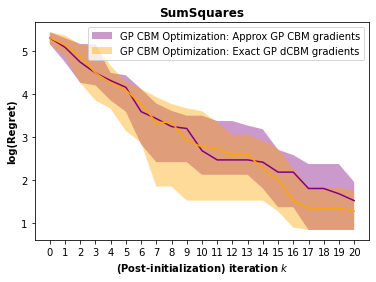

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Purple')
plt.plot(median_exact, color = 'Orange')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Purple', alpha=0.4, label='GP CBM Optimization: Approx GP CBM gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Orange', alpha=0.4, label='GP CBM Optimization: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact

(111.40043926239014, 354.0327093601227)

In [100]:
exact21_results, exact21_results[19:20].index[0]


(           0
 5   3.118194
 17  2.276226
 1   1.888285
 7   1.837462
 13  1.761773
 9   1.526867
 8   1.511644
 0   1.383632
 12  1.353466
 19  1.280707
 18  1.235272
 10  1.227716
 4   1.140922
 15  0.901836
 11  0.847827
 3   0.747839
 6   0.518893
 16  0.496909
 2   0.303862
 14  0.109841, 14)

In [101]:
str_exact = str(exact21_results[19:20].index[0]+1)
str_exact


'15'

In [102]:
eval_exactMinIQR_vsCorrApproxExperiment = eval('approx_' + str_exact)
eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc = eval_exactMinIQR_vsCorrApproxExperiment.history[eval_exactMinIQR_vsCorrApproxExperiment.history.index(eval_exactMinIQR_vsCorrApproxExperiment.tau)-1]
eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret = np.log(-eval_exactMinIQR_vsCorrApproxExperiment.tau + y_global_orig)

eval_exactMinIQR_vsCorrApproxExperiment.tau, eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc, eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret


(-2.936087197988206, -2.395544427848396, 1.0770778098985088)

In [103]:
### Final iteration: best "approx" experiment results (as above)

np.random.seed(int(str_exact))
eval_exactMinIQR_vsCorrApproxExperiment.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 6.97635395 -6.4220815 ]	 -131.15577599697437	 -20.897907943365695	    
init	 [-8.91273571 -2.76923108]	 -94.77413943464936	 -20.897907943365695	    
init	 [-4.49198143  0.6000045 ]	 -20.897907943365695	 -20.897907943365695	    
init	 [-3.88162169 -3.91051282]	 -45.651207890195394	 -20.897907943365695	    
init	 [-7.76517448 -5.00201972]	 -110.33833725681367	 -20.897907943365695	    
1  	 [-1.08003705  9.49213271]	 -181.3676469637466	 -20.897907943365695	 -2.4494900512168254
2  	 [10. 10.]	 -300.0	 -20.897907943365695	 -2.4494900512168254
3  	 [3.69182439 3.52226735]	 -38.44230185968878	 -20.897907943365695	 -2.449490051198033
4  	 [-9.85336983  7.92181089]	 -222.59907269893387	 -20.897907943365695	 -2.449490051216825
5  	 [ -2.24037026 -10.        ]	 -205.01925888356232	 -20.897907943365695	 -2.449489998553225
6  	 [10.          2.38189307]	 -111.34682918560738	 -20.897907943365695	 -2.44949002824

In [104]:
eval_exactMinIQR_vsCorrApproxExperiment.x_best, np.round(eval_exactMinIQR_vsCorrApproxExperiment.f_best, 2), eval_exactMinIQR_vsCorrApproxExperiment.best, eval_exactMinIQR_vsCorrApproxExperiment.x_best[np.argmin(eval_exactMinIQR_vsCorrApproxExperiment.f_best)] #### i.e. minAcqFunc returned


(array([[ -6.57365348,   2.60635001],
        [  1.10195303,   6.0963687 ],
        [ -6.01772321,  -8.57917205],
        [  3.89828579,  -4.23870211],
        [  3.8982912 ,  -4.23868699],
        [ -6.01771294,  -8.57916685],
        [ 10.        ,  -0.38981987],
        [ -1.23783021,  -0.83777965],
        [-10.        ,  10.        ],
        [ -3.2993105 ,   2.86078563],
        [  6.5108657 , -10.        ],
        [  1.10195661,   6.09637564],
        [  6.51086532, -10.        ],
        [  1.79381937,  10.        ],
        [  9.00589702,  -0.33876231],
        [ -1.23784529,  -0.83783183],
        [  9.0058974 ,  -0.33876236],
        [  6.46685977,   2.0533379 ],
        [ -1.23783921,  -0.83788554],
        [ -1.23782416,  -0.83781817]]),
 array([-2.02, -2.38, -2.38, -2.31, -2.31, -2.38, -0.05, -2.4 , 10.27,
        -1.36, -1.64, -2.38, -1.64,  0.21, -0.43, -2.4 , -0.43, -2.09,
        -2.4 , -2.4 ]),
 array([-1.23782416, -0.83781817]),
 array([-1.23782416, -0.83781817]))

In [105]:
eval_exactMinIQR = eval('exact_' + str_exact)
eval_exactMinIQR_maxAcqFunc = eval_exactMinIQR.history[eval_exactMinIQR.history.index(eval_exactMinIQR.tau)-1]
eval_exactMinIQR_simpleRegret  = np.log(-eval_exactMinIQR.tau + y_global_orig)

eval_exactMinIQR.tau, eval_exactMinIQR_maxAcqFunc, eval_exactMinIQR_simpleRegret


(-1.1161005150952463, -2.416819969944444, 0.10984092719295163)

In [106]:
### Final iteration: best "exact" experiment results (as above)

np.random.seed(int(str_exact))
eval_exactMinIQR.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         Max AcqFunc.
init	 [ 6.97635395 -6.4220815 ]	 -131.15577599697437	 -20.897907943365695	    
init	 [-8.91273571 -2.76923108]	 -94.77413943464936	 -20.897907943365695	    
init	 [-4.49198143  0.6000045 ]	 -20.897907943365695	 -20.897907943365695	    
init	 [-3.88162169 -3.91051282]	 -45.651207890195394	 -20.897907943365695	    
init	 [-7.76517448 -5.00201972]	 -110.33833725681367	 -20.897907943365695	    
1  	 [10. 10.]	 -300.0	 -20.897907943365695	 -2.449489748092488
2  	 [-9.69991687  7.99454818]	 -221.91398842692476	 -20.897907943365695	 -2.449489748092488
3  	 [0.20513286 9.70412013]	 -188.3819746546224	 -20.897907943365695	 -2.449489748092488
4  	 [8.17696818 1.09984692]	 -69.28213505909017	 -20.897907943365695	 -2.4494897480759805
5  	 [1.2981086  3.27985936]	 -23.200040829137844	 -20.897907943365695	 -2.449489676212509
6  	 [-0.62952455 -9.52479128]	 -181.8395990317211	 -20.897907943365695	 -2.4494897316038236
7	

In [107]:
eval_exactMinIQR.x_best, np.round(eval_exactMinIQR.f_best, 2), eval_exactMinIQR.best, eval_exactMinIQR.x_best[np.argmin(eval_exactMinIQR.f_best)] #### i.e. minAcqFunc returned, then multiply by -1 (NB!)


(array([[ -6.47866869,   3.75120845],
        [ -1.453143  ,   6.91427799],
        [ -1.32157894,  -1.5619157 ],
        [ -0.41489666,  -5.88008218],
        [  9.44730402,   0.58846125],
        [ -7.80869808,  -7.87803145],
        [  9.89827893,   7.49344209],
        [ -1.82725737,   1.24632389],
        [  8.16443249,   7.48838902],
        [ -6.99318186,  -0.16186997],
        [  3.16527622, -10.        ],
        [ -1.17270962,   1.22704628],
        [  2.19306052,  -0.64264765],
        [  5.1682549 ,  10.        ],
        [  7.53068699,  -1.20571731],
        [ -1.62130362,  -1.29662429],
        [ -1.08469572,  -1.9285924 ],
        [ 10.        ,   2.484394  ],
        [ -5.00259217,  -1.81909596],
        [  3.13205804,   4.75337474]]),
 array([-2.33, -1.31, -2.26, -2.13, 11.32,  2.28, 12.34, -1.38,  1.56,
        -1.84, -2.06, -1.66, -0.68, -2.43,  2.43, -2.23, -2.24,  1.28,
        -0.57, -1.12]),
 array([ 5.1682549, 10.       ]),
 array([ 5.1682549, 10.       ]))

In [108]:
eval_exactMinIQR.tau > eval_exactMinIQR_vsCorrApproxExperiment.tau # Exact gradients' model: is y-value greater?

True

In [109]:
eval_exactMinIQR_maxAcqFunc > eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc # Exact gradients' model: is best AcqFunc greater?


False

In [110]:
eval_exactMinIQR_simpleRegret < eval_exactMinIQR_vsCorrApproxExperiment_simpleRegret # Exact gradients' model: simple regret's natural log lower?


True

In [111]:
eval_exactMinIQR_maxAcqFunc, eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc, eval_exactMinIQR_maxAcqFunc/eval_exactMinIQR_vsCorrApproxExperiment_maxAcqFunc


(-2.416819969944444, -2.395544427848396, 1.0088812972319436)

In [112]:
### MaxAcqFunc Comparison: Approximate Gradients

approx_1maxAcqFunc = approx_1.history[:-1][1::2]
approx_2maxAcqFunc = approx_2.history[:-1][1::2]
approx_3maxAcqFunc = approx_3.history[:-1][1::2]
approx_4maxAcqFunc = approx_4.history[:-1][1::2]
approx_5maxAcqFunc = approx_5.history[:-1][1::2]
approx_6maxAcqFunc = approx_6.history[:-1][1::2]
approx_7maxAcqFunc = approx_7.history[:-1][1::2]
approx_8maxAcqFunc = approx_8.history[:-1][1::2]
approx_9maxAcqFunc = approx_9.history[:-1][1::2]
approx_10maxAcqFunc = approx_10.history[:-1][1::2]
approx_11maxAcqFunc = approx_11.history[:-1][1::2]
approx_12maxAcqFunc = approx_12.history[:-1][1::2]
approx_13maxAcqFunc = approx_13.history[:-1][1::2]
approx_14maxAcqFunc = approx_14.history[:-1][1::2]
approx_15maxAcqFunc = approx_15.history[:-1][1::2]
approx_16maxAcqFunc = approx_16.history[:-1][1::2]
approx_17maxAcqFunc = approx_17.history[:-1][1::2]
approx_18maxAcqFunc = approx_18.history[:-1][1::2]
approx_19maxAcqFunc = approx_19.history[:-1][1::2]
approx_20maxAcqFunc = approx_20.history[:-1][1::2]


In [113]:
### MaxAcqFunc Comparison: Exact Gradients

exact_1maxAcqFunc = exact_1.history[:-1][1::2]
exact_2maxAcqFunc = exact_2.history[:-1][1::2]
exact_3maxAcqFunc = exact_3.history[:-1][1::2]
exact_4maxAcqFunc = exact_4.history[:-1][1::2]
exact_5maxAcqFunc = exact_5.history[:-1][1::2]
exact_6maxAcqFunc = exact_6.history[:-1][1::2]
exact_7maxAcqFunc = exact_7.history[:-1][1::2]
exact_8maxAcqFunc = exact_8.history[:-1][1::2]
exact_9maxAcqFunc = exact_9.history[:-1][1::2]
exact_10maxAcqFunc = exact_10.history[:-1][1::2]
exact_11maxAcqFunc = exact_11.history[:-1][1::2]
exact_12maxAcqFunc = exact_12.history[:-1][1::2]
exact_13maxAcqFunc = exact_13.history[:-1][1::2]
exact_14maxAcqFunc = exact_14.history[:-1][1::2]
exact_15maxAcqFunc = exact_15.history[:-1][1::2]
exact_16maxAcqFunc = exact_16.history[:-1][1::2]
exact_17maxAcqFunc = exact_17.history[:-1][1::2]
exact_18maxAcqFunc = exact_18.history[:-1][1::2]
exact_19maxAcqFunc = exact_19.history[:-1][1::2]
exact_20maxAcqFunc = exact_20.history[:-1][1::2]


In [114]:
### MaxAcqFunc Comparison: Experiment 1

maxAcqFuncApprox1 = np.mean(approx_1maxAcqFunc)
maxAcqFuncExact1 = np.mean(exact_1maxAcqFunc)
ratio1 = maxAcqFuncApprox1/maxAcqFuncExact1
approx_1.tau, exact_1.tau, maxAcqFuncApprox1, maxAcqFuncExact1, ratio1


(-5.468172821636052,
 -3.989366671349296,
 -2.4334391395612616,
 -2.431814533928937,
 1.0006680631313194)

In [115]:
### MaxAcqFunc Comparison: Experiment 2

maxAcqFuncApprox2 = np.mean(approx_2maxAcqFunc)
maxAcqFuncExact2 = np.mean(exact_2maxAcqFunc)
ratio2 = maxAcqFuncApprox2/maxAcqFuncExact2
approx_2.tau, exact_2.tau, maxAcqFuncApprox2, maxAcqFuncExact2, ratio2


(-4.333099000920773,
 -4.333099000920773,
 -2.435831109963724,
 -2.4384698808140137,
 0.998917857927608)

In [116]:
### MaxAcqFunc Comparison: Experiment 3

maxAcqFuncApprox3 = np.mean(approx_3maxAcqFunc)
maxAcqFuncExact3 = np.mean(exact_3maxAcqFunc)
ratio3 = maxAcqFuncApprox3/maxAcqFuncExact3
approx_3.tau, exact_3.tau, maxAcqFuncApprox3, maxAcqFuncExact3, ratio3


(-1.4940122574729555,
 -1.3550814721388451,
 -2.4378474758416386,
 -2.424809770464892,
 1.0053767951348394)

In [117]:
### MaxAcqFunc Comparison: Experiment 4

maxAcqFuncApprox4 = np.mean(approx_4maxAcqFunc)
maxAcqFuncExact4 = np.mean(exact_4maxAcqFunc)
ratio4 = maxAcqFuncApprox4/maxAcqFuncExact4
approx_4.tau, exact_4.tau, maxAcqFuncApprox4, maxAcqFuncExact4, ratio4


(-6.164093316540281,
 -2.112430794758758,
 -2.4396980641164068,
 -2.427381079780621,
 1.005074186512527)

In [118]:
### MaxAcqFunc Comparison: Experiment 5

maxAcqFuncApprox5 = np.mean(approx_5maxAcqFunc)
maxAcqFuncExact5 = np.mean(exact_5maxAcqFunc)
ratio5 = maxAcqFuncApprox5/maxAcqFuncExact5
approx_5.tau, exact_5.tau, maxAcqFuncApprox5, maxAcqFuncExact5, ratio5


(-10.04307293518387,
 -3.1296539594564723,
 -2.441190909221252,
 -2.4371684289102022,
 1.0016504728451814)

In [119]:
### MaxAcqFunc Comparison: Experiment 6

maxAcqFuncApprox6 = np.mean(approx_6maxAcqFunc)
maxAcqFuncExact6 = np.mean(exact_6maxAcqFunc)
ratio6 = maxAcqFuncApprox6/maxAcqFuncExact6
approx_6.tau, exact_6.tau, maxAcqFuncApprox6, maxAcqFuncExact6, ratio6


(-5.629416961321397,
 -5.629416961321397,
 -2.4373712111210066,
 -2.416262140807481,
 1.0087362500769355)

In [120]:
### MaxAcqFunc Comparison: Experiment 7

maxAcqFuncApprox7 = np.mean(approx_7maxAcqFunc)
maxAcqFuncExact7 = np.mean(exact_7maxAcqFunc)
ratio7 = maxAcqFuncApprox7/maxAcqFuncExact7
approx_7.tau, exact_7.tau, maxAcqFuncApprox7, maxAcqFuncExact7, ratio7


(-1.1304937775218953,
 -1.680166903504158,
 -2.4368243193975045,
 -2.438714420319916,
 0.9992249601238002)

In [121]:
### MaxAcqFunc Comparison: Experiment 8

maxAcqFuncApprox8 = np.mean(approx_8maxAcqFunc)
maxAcqFuncExact8 = np.mean(exact_8maxAcqFunc)
ratio8 = maxAcqFuncApprox8/maxAcqFuncExact8
approx_8.tau, exact_8.tau, maxAcqFuncApprox8, maxAcqFuncExact8, ratio8


(-0.5791878792948744,
 -0.5791878792948744,
 -2.4449392030617556,
 -2.429860852784665,
 1.0062054377557508)

In [122]:
### MaxAcqFunc Comparison: Experiment 9

maxAcqFuncApprox9 = np.mean(approx_9maxAcqFunc)
maxAcqFuncExact9 = np.mean(exact_9maxAcqFunc)
ratio9 = maxAcqFuncApprox9/maxAcqFuncExact9
approx_9.tau, exact_9.tau, maxAcqFuncApprox9, maxAcqFuncExact9, ratio9


(-2.6071501432266673,
 -4.5341773833992,
 -2.443010488322702,
 -2.425256893227861,
 1.0073202946642126)

In [123]:
### MaxAcqFunc Comparison: Experiment 10

maxAcqFuncApprox10 = np.mean(approx_10maxAcqFunc)
maxAcqFuncExact10 = np.mean(exact_10maxAcqFunc)
ratio10 = maxAcqFuncApprox10/maxAcqFuncExact10
approx_10.tau, exact_10.tau, maxAcqFuncApprox10, maxAcqFuncExact10, ratio10


(-4.603728884330075,
 -4.603728884330075,
 -2.4408729498413004,
 -2.4311730658911372,
 1.0039897957435653)

In [124]:
### MaxAcqFunc Comparison: Experiment 11

maxAcqFuncApprox11 = np.mean(approx_11maxAcqFunc)
maxAcqFuncExact11 = np.mean(exact_11maxAcqFunc)
ratio11 = maxAcqFuncApprox11/maxAcqFuncExact11
approx_11.tau, exact_11.tau, maxAcqFuncApprox11, maxAcqFuncExact11, ratio11


(-2.716881462565864,
 -2.716881462565864,
 -2.4360594415053476,
 -2.4269762559776638,
 1.0037425934865707)

In [125]:
### MaxAcqFunc Comparison: Experiment 12

maxAcqFuncApprox12 = np.mean(approx_12maxAcqFunc)
maxAcqFuncExact12 = np.mean(exact_12maxAcqFunc)
ratio12 = maxAcqFuncApprox12/maxAcqFuncExact12
approx_12.tau, exact_12.tau, maxAcqFuncApprox12, maxAcqFuncExact12, ratio12


(-2.332812503650805,
 -2.3345680980475185,
 -2.435718070106632,
 -2.426626910402157,
 1.0037464183989324)

In [126]:
### MaxAcqFunc Comparison: Experiment 13

maxAcqFuncApprox13 = np.mean(approx_13maxAcqFunc)
maxAcqFuncExact13 = np.mean(exact_13maxAcqFunc)
ratio13 = maxAcqFuncApprox13/maxAcqFuncExact13
approx_13.tau, exact_13.tau, maxAcqFuncApprox13, maxAcqFuncExact13, ratio13


(-6.1041633558475406,
 -3.870817922701323,
 -2.444186271175517,
 -2.430806543736741,
 1.005504233758647)

In [127]:
### MaxAcqFunc Comparison: Experiment 14

maxAcqFuncApprox14 = np.mean(approx_14maxAcqFunc)
maxAcqFuncExact14 = np.mean(exact_14maxAcqFunc)
ratio14 = maxAcqFuncApprox14/maxAcqFuncExact14
approx_14.tau, exact_14.tau, maxAcqFuncApprox14, maxAcqFuncExact14, ratio14


(-3.651510611844004,
 -5.822752140657417,
 -2.4358356709552136,
 -2.430365869548997,
 1.0022506082210707)

In [128]:
### MaxAcqFunc Comparison: Experiment 15

maxAcqFuncApprox15 = np.mean(approx_15maxAcqFunc)
maxAcqFuncExact15 = np.mean(exact_15maxAcqFunc)
ratio15 = maxAcqFuncApprox15/maxAcqFuncExact15
approx_15.tau, exact_15.tau, maxAcqFuncApprox15, maxAcqFuncExact15, ratio15


(-2.936087197988206,
 -1.1161005150952463,
 -8.532459959081839,
 -9.141371680250955,
 0.9333894581176903)

In [129]:
### MaxAcqFunc Comparison: Experiment 16

maxAcqFuncApprox16 = np.mean(approx_16maxAcqFunc)
maxAcqFuncExact16 = np.mean(exact_16maxAcqFunc)
ratio16 = maxAcqFuncApprox16/maxAcqFuncExact16
approx_16.tau, exact_16.tau, maxAcqFuncApprox16, maxAcqFuncExact16, ratio16


(-1.9926048821287814,
 -2.4641223318645973,
 -2.440756923502654,
 -2.4379996836313147,
 1.001130943490211)

In [130]:
### MaxAcqFunc Comparison: Experiment 17

maxAcqFuncApprox17 = np.mean(approx_17maxAcqFunc)
maxAcqFuncExact17 = np.mean(exact_17maxAcqFunc)
ratio17 = maxAcqFuncApprox17/maxAcqFuncExact17
approx_17.tau, exact_17.tau, maxAcqFuncApprox17, maxAcqFuncExact17, ratio17


(-0.7140953202631145,
 -1.643633091965647,
 -2.434827753364188,
 -2.4428029963975955,
 0.9967352082647809)

In [131]:
### MaxAcqFunc Comparison: Experiment 18

maxAcqFuncApprox18 = np.mean(approx_18maxAcqFunc)
maxAcqFuncExact18 = np.mean(exact_18maxAcqFunc)
ratio18 = maxAcqFuncApprox18/maxAcqFuncExact18
approx_18.tau, exact_18.tau, maxAcqFuncApprox18, maxAcqFuncExact18, ratio18


(-1.2854373711962621,
 -9.068756459576363,
 -2.4436816363086877,
 -2.4375616534514477,
 1.002510698692923)

In [132]:
### MaxAcqFunc Comparison: Experiment 19

maxAcqFuncApprox19 = np.mean(approx_19maxAcqFunc)
maxAcqFuncExact19 = np.mean(exact_19maxAcqFunc)
ratio19 = maxAcqFuncApprox19/maxAcqFuncExact19
approx_19.tau, exact_19.tau, maxAcqFuncApprox19, maxAcqFuncExact19, ratio19


(-10.574345906063899,
 -3.43931266960188,
 -2.442325499962946,
 -2.43547848808202,
 1.002811362085287)

In [133]:
### MaxAcqFunc Comparison: Experiment 20

maxAcqFuncApprox20 = np.mean(approx_20maxAcqFunc)
maxAcqFuncExact20 = np.mean(exact_20maxAcqFunc)
ratio20 = maxAcqFuncApprox20/maxAcqFuncExact20
approx_20.tau, exact_20.tau, maxAcqFuncApprox20, maxAcqFuncExact20, ratio20


(-6.161449614183514,
 -3.59918227441426,
 -2.4412213758062333,
 -2.435907537077419,
 1.0021814615899542)

In [134]:
num = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ApproxTau = [approx_1.tau,approx_2.tau,approx_3.tau,approx_4.tau,approx_5.tau,approx_6.tau,approx_7.tau,approx_8.tau,approx_9.tau,approx_10.tau,approx_11.tau,approx_12.tau,approx_13.tau,approx_14.tau,approx_15.tau,approx_16.tau,approx_17.tau,approx_18.tau,approx_19.tau,approx_20.tau]
ExactTau = [exact_1.tau,exact_2.tau,exact_3.tau,exact_4.tau,exact_5.tau,exact_6.tau,exact_7.tau,exact_8.tau,exact_9.tau,exact_10.tau,exact_11.tau,exact_12.tau,exact_13.tau,exact_14.tau,exact_15.tau,exact_16.tau,exact_17.tau,exact_18.tau,exact_19.tau,exact_20.tau]
AvgMaxAcqFuncExact = [maxAcqFuncExact1,maxAcqFuncExact2,maxAcqFuncExact3,maxAcqFuncExact4,maxAcqFuncExact5,maxAcqFuncExact6,maxAcqFuncExact7,maxAcqFuncExact8,maxAcqFuncExact9,maxAcqFuncExact10,maxAcqFuncExact11,maxAcqFuncExact12,maxAcqFuncExact13,maxAcqFuncExact14,maxAcqFuncExact15,maxAcqFuncExact16,maxAcqFuncExact17,maxAcqFuncExact18,maxAcqFuncExact19,maxAcqFuncExact20]
AvgMaxAcqFuncApprox = [maxAcqFuncApprox1,maxAcqFuncApprox2,maxAcqFuncApprox3,maxAcqFuncApprox4,maxAcqFuncApprox5,maxAcqFuncApprox6,maxAcqFuncApprox7,maxAcqFuncApprox8,maxAcqFuncApprox9,maxAcqFuncApprox10,maxAcqFuncApprox11,maxAcqFuncApprox12,maxAcqFuncApprox13,maxAcqFuncApprox14,maxAcqFuncApprox15,maxAcqFuncApprox16,maxAcqFuncApprox17,maxAcqFuncApprox18,maxAcqFuncApprox19,maxAcqFuncApprox20]
ratio = [ratio1,ratio2,ratio3,ratio4,ratio5,ratio6,ratio7,ratio8,ratio9,ratio10,ratio11,ratio12,ratio13,ratio14,ratio15,ratio16,ratio17,ratio18,ratio19,ratio20]


In [135]:
def greaterThan(a, b):
  lis =[]
  #convert to list
  a = list(a)
  b = list(b)
  c = "Yes"
  d = "No"
  e = "equal"
  for first, first_te in zip(a, b):
      if first < first_te:
          lis.append(d)
      elif first > first_te:
          lis.append(c)
      else:
          lis.append(e)
  return lis

greaterAcqFunc = greaterThan(AvgMaxAcqFuncExact, AvgMaxAcqFuncApprox)


In [136]:
def greaterRatio(a):
  lis =[]
  #convert to list
  a = list(a)
  b = "Yes"
  c = "No"
  d = "equal"
  for first, in zip(a):
      if first < 1:
          lis.append(c)
      elif first > 1:
          lis.append(b)
      else:
          lis.append(d)
  return lis

greaterRatio = greaterRatio(ratio)


In [137]:
df = pd.DataFrame(dict(Experiment=num,
                  ExactTau=ExactTau,
                  ApproxTau=ApproxTau,
                  AvgMaxAcqFuncExact=AvgMaxAcqFuncExact,
                  GreaterAcqFunc = greaterAcqFunc,
                  AvgMaxAcqFuncApprox=AvgMaxAcqFuncApprox,
                  Ratio = ratio,
                  GreaterRatio = greaterRatio))
df.sort_values(by=['ExactTau'], inplace=True, ascending=False)
print(df.to_latex(index=False))


\begin{tabular}{rrrrlrrl}
\toprule
 Experiment &  ExactTau &  ApproxTau &  AvgMaxAcqFuncExact & GreaterAcqFunc &  AvgMaxAcqFuncApprox &    Ratio & GreaterRatio \\
\midrule
          8 & -0.579188 &  -0.579188 &           -2.429861 &            Yes &            -2.444939 & 1.006205 &          Yes \\
         15 & -1.116101 &  -2.936087 &           -9.141372 &             No &            -8.532460 & 0.933389 &           No \\
          3 & -1.355081 &  -1.494012 &           -2.424810 &            Yes &            -2.437847 & 1.005377 &          Yes \\
         17 & -1.643633 &  -0.714095 &           -2.442803 &             No &            -2.434828 & 0.996735 &           No \\
          7 & -1.680167 &  -1.130494 &           -2.438714 &             No &            -2.436824 & 0.999225 &           No \\
          4 & -2.112431 &  -6.164093 &           -2.427381 &            Yes &            -2.439698 & 1.005074 &          Yes \\
         12 & -2.334568 &  -2.332813 &           -2.426627 &

In [138]:
avg_list = ['ExactTau', 'ApproxTau', 'AvgMaxAcqFuncExact','AvgMaxAcqFuncApprox']
avg = df[avg_list].mean()
avg.name = 'Average'
df = df.append(avg.transpose())
df.fillna(value='', inplace=True)
df


,Experiment,ExactTau,ApproxTau,AvgMaxAcqFuncExact,GreaterAcqFunc,AvgMaxAcqFuncApprox,Ratio,GreaterRatio
7,8.0,-0.579188,-0.579188,-2.429861,Yes,-2.444939,1.006205,Yes
14,15.0,-1.116101,-2.936087,-9.141372,No,-8.532460,0.933389,No
2,3.0,-1.355081,-1.494012,-2.424810,Yes,-2.437847,1.005377,Yes
16,17.0,-1.643633,-0.714095,-2.442803,No,-2.434828,0.996735,No
6,7.0,-1.680167,-1.130494,-2.438714,No,-2.436824,0.999225,No
3,4.0,-2.112431,-6.164093,-2.427381,Yes,-2.439698,1.005074,Yes
11,12.0,-2.334568,-2.332813,-2.426627,Yes,-2.435718,1.003746,Yes
15,16.0,-2.464122,-1.992605,-2.438000,Yes,-2.440757,1.001131,Yes
10,11.0,-2.716881,-2.716881,-2.426976,Yes,-2.436059,1.003743,Yes
4,5.0,-3.129654,-10.043073,-2.437168,Yes,-2.441191,1.00165,Yes


In [139]:
print('Ratio of Average ExactTau to Average ApproxTau:', np.round(avg[1]/avg[0], 5))
print('Ratio of Average AvgMaxAcqFuncExact to Average AvgMaxAcqFuncApprox:', np.round(avg[3]/avg[2], 5))
print('Number of experiments where AvgMaxAcqFuncExact exceeds AvgMaxAcqFuncApprox:', df['GreaterAcqFunc'].value_counts()['Yes'])
print('Number of experiments where Ratio exceeds 1.0:', df['GreaterRatio'].value_counts()['Yes'])


Ratio of Average ExactTau to Average ApproxTau: 1.18375
Ratio of Average AvgMaxAcqFuncExact to Average AvgMaxAcqFuncApprox: 0.99153
Number of experiments where AvgMaxAcqFuncExact exceeds AvgMaxAcqFuncApprox: 16
Number of experiments where Ratio exceeds 1.0: 16
